In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

    # Define columns for processing
    time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']  # Adjust if necessary

    # Columns for correlation matrix
    corr_columns = [
        'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 
        'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 
        'canopy_temp', 'VWC_06', 'VWC_18', 'VWC_30', 'VWC_42', 'plot_number', 
        'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
    ]

    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[corr_columns + time_columns].interpolate(method='pchip')

    return df



In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Data Preparation Function
def prepare_data(df, time_columns, continuous_columns, target_column):
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[continuous_columns] = scaler.fit_transform(df[continuous_columns])
    return df_scaled

# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + 1):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)

# Model Definition Function
def build_model(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dense(96)
    ])
    model.compile(optimizer=Adam(), loss='mse')
    return model

def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val


# Main Function to Execute Workflow
def run_workflow(df, time_columns, continuous_columns, target_column, input_window, forecast_horizon, stride, epochs, batch_size):
    df_processed = prepare_data(df, time_columns, continuous_columns, target_column)
    input_data = df_processed[time_columns + continuous_columns].values
    target_data = df_processed[target_column].values
    X, y = create_sequences(input_data, target_data, input_window, forecast_horizon, stride)
    X_train, X_val, y_train, y_val = chronological_split(X, y)

    model = build_model((input_window, X.shape[2]))

    # Define the checkpoint path and directory
    checkpoint_path = "LSTM/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                     save_weights_only=False,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True,
                                                     verbose=1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit model with callbacks
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, cp_callback])


# Example Usage
df_2014 = process_data_for_plot(2014)  # Assuming df_2014 is loaded and time-indexed appropriately
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 'canopy_temp',
    'VWC_06', 'VWC_18', 'VWC_30', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]
target_column = 'VWC_06'

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 20
batch_size = 32  # Adjust based on your dataset size and memory capacityz

run_workflow(df_2014, time_columns, continuous_columns, target_column, input_window, forecast_horizon, stride, epochs, batch_size)


Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.1920
Epoch 1: val_loss improved from inf to 0.09363, saving model to LSTM
INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 14s 749ms/step - loss: 0.1920 - val_loss: 0.0936
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.0570
Epoch 2: val_loss improved from 0.09363 to 0.04465, saving model to LSTM
INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 10s 752ms/step - loss: 0.0570 - val_loss: 0.0446
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.0390
Epoch 3: val_loss improved from 0.04465 to 0.04446, saving model to LSTM
INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 11s 831ms/step - loss: 0.0390 - val_loss: 0.0445
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.0376
Epoch 4: val_loss did not improve from 0.04446
14/14 [==============================] - 5s 329ms/step - loss: 0.0376 - val_loss: 0.0504
Epoch 5/20
14/14 [==============================] - ETA: 0s - loss: 0.0430
Epoch 5: val_loss improved from 0.04446 to 0.04164, saving model to LSTM
INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 11s 841ms/step - loss: 0.0430 - val_loss: 0.0416
Epoch 6/20
14/14 [==============================] - ETA: 0s - loss: 0.0397
Epoch 6: val_loss did not improve from 0.04164
14/14 [==============================] - 4s 318ms/step - loss: 0.0397 - val_loss: 0.0425
Epoch 7/20
14/14 [==============================] - ETA: 0s - loss: 0.0385
Epoch 7: val_loss improved from 0.04164 to 0.04006, saving model to LSTM
INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 11s 807ms/step - loss: 0.0385 - val_loss: 0.0401
Epoch 8/20
14/14 [==============================] - ETA: 0s - loss: 0.0363
Epoch 8: val_loss did not improve from 0.04006
14/14 [==============================] - 5s 324ms/step - loss: 0.0363 - val_loss: 0.0401
Epoch 9/20
14/14 [==============================] - ETA: 0s - loss: 0.0314
Epoch 9: val_loss did not improve from 0.04006
14/14 [==============================] - 4s 317ms/step - loss: 0.0314 - val_loss: 0.0420
Epoch 10/20
14/14 [==============================] - ETA: 0s - loss: 0.0276
Epoch 10: val_loss did not improve from 0.04006
14/14 [==============================] - 4s 311ms/step - loss: 0.0276 - val_loss: 0.0403
Epoch 11/20
14/14 [==============================] - ETA: 0s - loss: 0.0242
Epoch 11: val_loss did not improve from 0.04006
14/14 [==============================] - 3s 243ms/step - loss: 0.0242 - val_loss: 0.0418
Epoch 12/20
14/14 [==============================] - ETA: 0s -

INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 9s 653ms/step - loss: 0.0216 - val_loss: 0.0384
Epoch 14/20
14/14 [==============================] - ETA: 0s - loss: 0.0204
Epoch 14: val_loss did not improve from 0.03843
14/14 [==============================] - 5s 357ms/step - loss: 0.0204 - val_loss: 0.0469
Epoch 15/20
14/14 [==============================] - ETA: 0s - loss: 0.0197
Epoch 15: val_loss did not improve from 0.03843
14/14 [==============================] - 5s 348ms/step - loss: 0.0197 - val_loss: 0.0445
Epoch 16/20
14/14 [==============================] - ETA: 0s - loss: 0.0186
Epoch 16: val_loss did not improve from 0.03843
14/14 [==============================] - 5s 352ms/step - loss: 0.0186 - val_loss: 0.0427
Epoch 17/20
14/14 [==============================] - ETA: 0s - loss: 0.0169
Epoch 17: val_loss did not improve from 0.03843
14/14 [==============================] - 4s 314ms/step - loss: 0.0169 - val_loss: 0.0408
Epoch 18/20
14/14 [==============================] - ETA: 0

INFO:tensorflow:Assets written to: LSTM\assets


14/14 [==============================] - 9s 650ms/step - loss: 0.0118 - val_loss: 0.0323


       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1056.000000  1056.000000  1056.000000  1056.000000  1056.000000   
mean      0.506017     0.388936     0.355637     0.276929     0.321436   
std       0.193450     0.229521     0.244662     0.217633     0.228126   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.367407     0.205590     0.151240     0.155039     0.188117   
50%       0.504497     0.355967     0.326981     0.211886     0.228307   
75%       0.648233     0.551783     0.534936     0.291990     0.419351   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              CWSI         SWSI   irrigation  precip_irrig  
count  1056.000000  1056.000000  1056.000000   1056.000000  
mean      0.404248     0.629332     0.003314      0.006098  
std       0.235100     0.233146     0.055404      0.063429  
min       0.000000     0.000000     0.000000      0.000000  
25%       0.284650     0.496

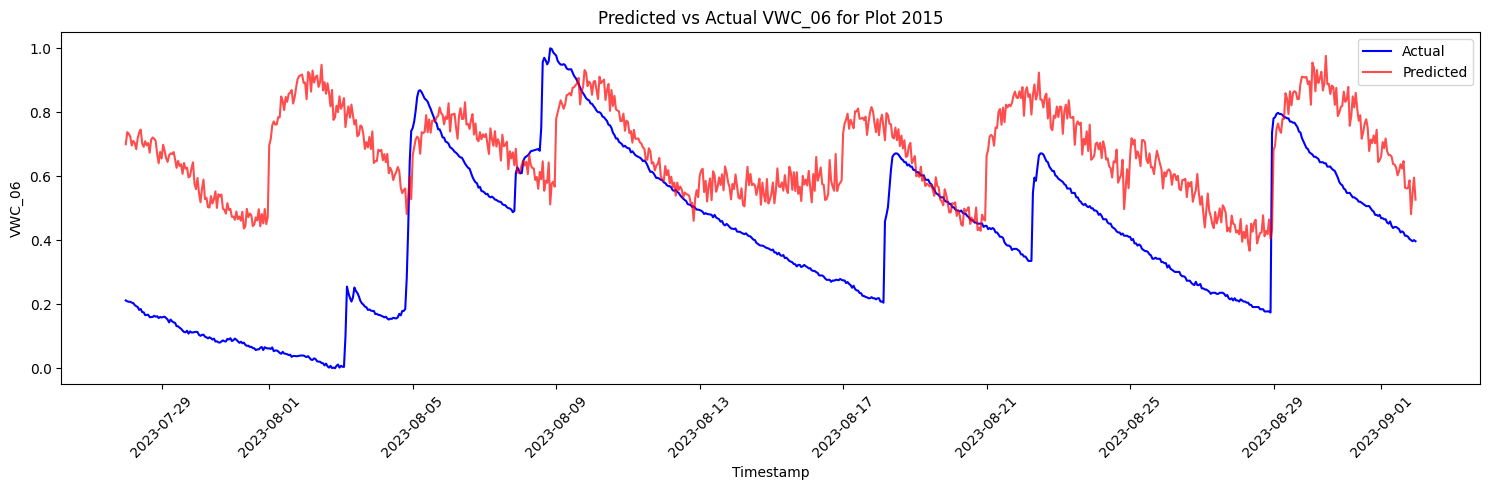

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Assuming 'prepare_data', 'create_sequences', 'build_model', 'chronological_split', and 'df_2014' are defined as per your instructions



def predict_with_sliding_window(model, df, input_window, forecast_horizon, time_columns, continuous_columns, target_column, plot_number):
    df_scaled = prepare_data(df, time_columns, continuous_columns, target_column)
    input_data = df_scaled[time_columns + continuous_columns].values
    target_data = df_scaled[target_column].values

    predictions = []
    actuals = []
    timestamps = []

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon

    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(time_columns) + len(continuous_columns)))
        
        pred = model.predict(sequence)
        predictions.append(pred.flatten()[:forecast_horizon])
        actuals.append(target_data[end:end + forecast_horizon])
        # Convert DatetimeIndex to Series before appending
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)



    # Flatten lists
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, actuals, label='Actual', color='blue')
    plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
    plt.legend()
    plt.title(f'Predicted vs Actual {target_column} for Plot {plot_number}')  
    plt.xlabel('Timestamp')
    plt.ylabel(target_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Model Loading
checkpoint_path = "./LSTM"

model = tf.keras.models.load_model(checkpoint_path)

plot_number = 2015
df_2015 = process_data_for_plot(plot_number)

df_2015 = prepare_data(df_2015, time_columns, continuous_columns, target_column)

# print statistics for the following columns: 'canopy_temp','VWC_06', 'VWC_18', 'VWC_30', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
cols_to_describe = ['canopy_temp','VWC_06', 'VWC_18', 'VWC_30', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig']
print(df_2015[cols_to_describe].describe())

# Assuming df_2014 is prepared with the same columns as your training data
predict_with_sliding_window(model, df_2015, input_window=24*7, forecast_horizon=96, time_columns=time_columns, continuous_columns=continuous_columns, target_column=target_column, plot_number=plot_number)

Statistics for the plot 2001:
       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1063.000000  1063.000000  1063.000000  1063.000000  1063.000000   
mean     23.560579    21.297798    13.374761    12.392467     2.730472   
std       5.947268     3.065718     1.986053     0.681621     1.293279   
min       8.222500    17.666667    11.666667    11.466667     0.918036   
25%      18.712758    18.600000    11.973555    12.068616     2.009606   
50%      23.375000    20.300000    12.300000    12.175000     2.267876   
75%      29.552900    23.300000    14.275000    12.375000     3.299471   
max      33.893967    29.925000    18.500000    14.800000     6.961435   

              CWSI         SWSI   irrigation  precip_irrig  
count  1063.000000  1063.000000  1063.000000   1063.000000  
mean      1.593075     0.786632     0.167262      0.156271  
std       1.587215     0.295203     1.980080      1.606695  
min       0.000000     0.088333     0.000000      0.000000 

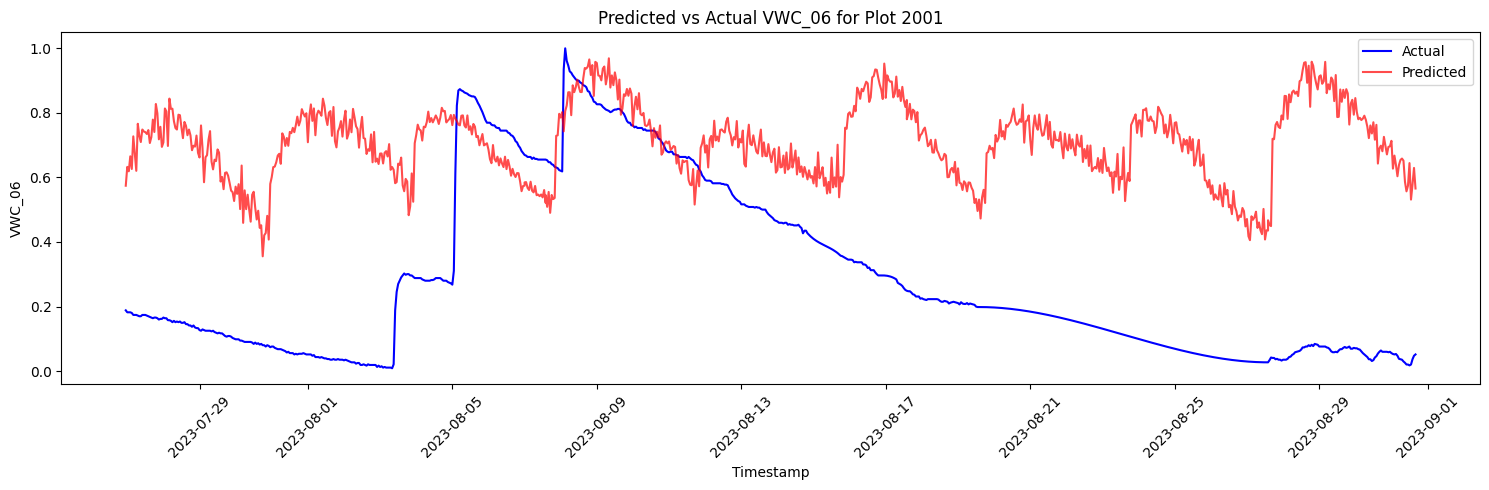

Statistics for the plot 2003:
       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1063.000000  1063.000000  1063.000000  1063.000000  1063.000000   
mean     22.845202    21.659867    14.041950    11.166845     2.730472   
std       5.062528     2.356454     2.174490     0.990700     1.293279   
min       9.365000    18.550000    11.616667     9.516667     0.918036   
25%      19.015000    19.748240    12.204288    10.597435     2.009606   
50%      23.207500    21.055334    13.175000    11.074298     2.267876   
75%      26.689592    23.025000    15.800000    11.500000     3.299471   
max      33.245017    28.250000    18.775000    13.525000     6.961435   

              CWSI         SWSI   irrigation  precip_irrig  
count  1063.000000  1063.000000  1063.000000   1063.000000  
mean      1.531202     0.877110     0.167262      0.156271  
std       1.440606     0.310885     1.980080      1.606695  
min       0.260865     0.230000     0.000000      0.000000 

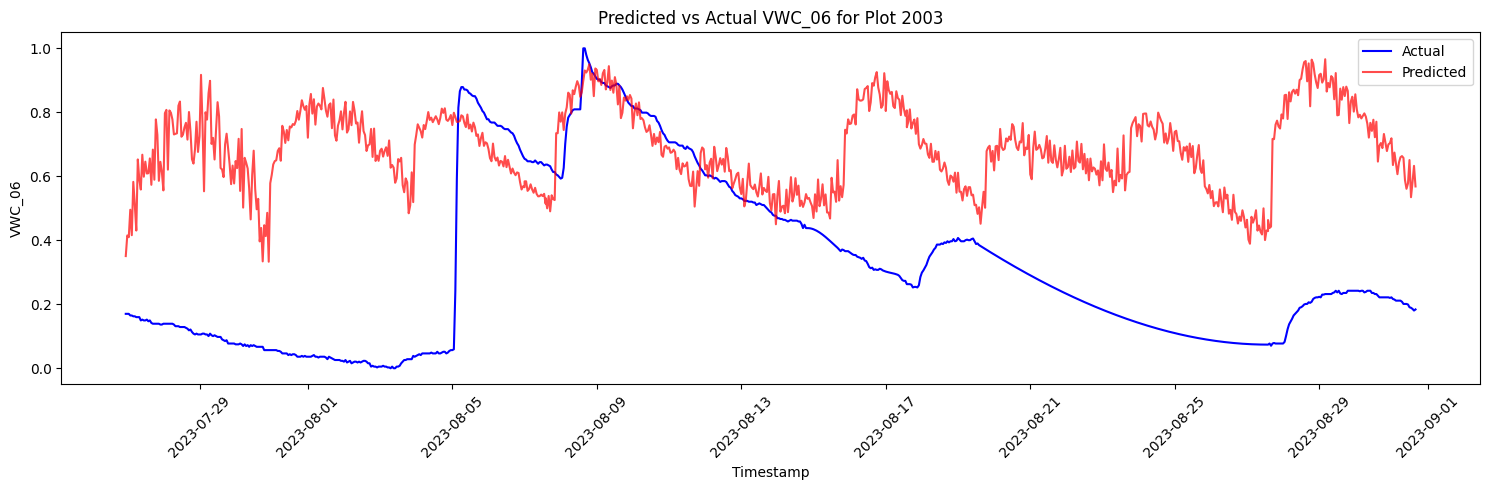

Statistics for the plot 2004:
       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1088.000000  1088.000000  1088.000000  1088.000000  1088.000000   
mean     21.901743    19.014759    14.146899    12.268779     2.810686   
std       5.418348     1.362784     0.559716     0.763547     1.390979   
min       5.692750    16.350000    13.400000    11.700000     0.918036   
25%      18.405625    18.178125    13.677939    11.850000     2.010284   
50%      21.828898    18.756250    14.075000    12.000000     2.296115   
75%      25.732232    19.825000    14.414286    12.135714     3.433808   
max      35.390000    22.200000    15.693750    14.962500     6.961435   

              CWSI         SWSI   irrigation  precip_irrig  
count  1088.000000  1088.000000  1088.000000   1088.000000  
mean      2.544032     0.971379     0.163419      0.152680  
std       0.836177     0.105094     1.957338      1.588284  
min       0.898364     0.632917     0.000000      0.000000 

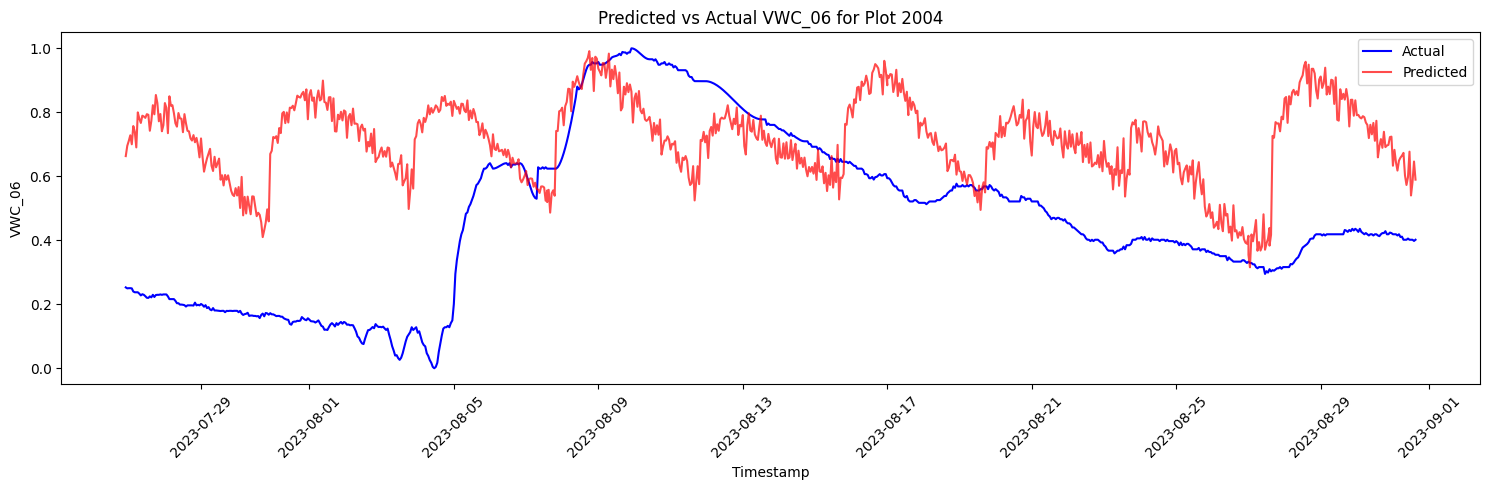

Statistics for the plot 2007:
       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1063.000000  1063.000000  1063.000000  1063.000000  1063.000000   
mean     24.131376    18.668815    14.510011    12.881070     2.730472   
std       6.135470     3.326817     1.246625     1.014957     1.293279   
min       9.532500    13.725000    12.600000    12.133333     0.918036   
25%      19.181250    15.950000    13.495871    12.360519     2.009606   
50%      24.521383    18.000000    14.375000    12.500000     2.267876   
75%      29.962232    20.700000    14.725000    12.700000     3.299471   
max      34.003283    27.100000    17.800000    16.375000     6.961435   

              CWSI         SWSI   irrigation  precip_irrig  
count  1063.000000  1063.000000  1063.000000   1063.000000  
mean      1.796707     0.926706     0.167262      0.156271  
std       1.499507     0.280021     1.980080      1.606695  
min       0.445673     0.206667     0.000000      0.000000 

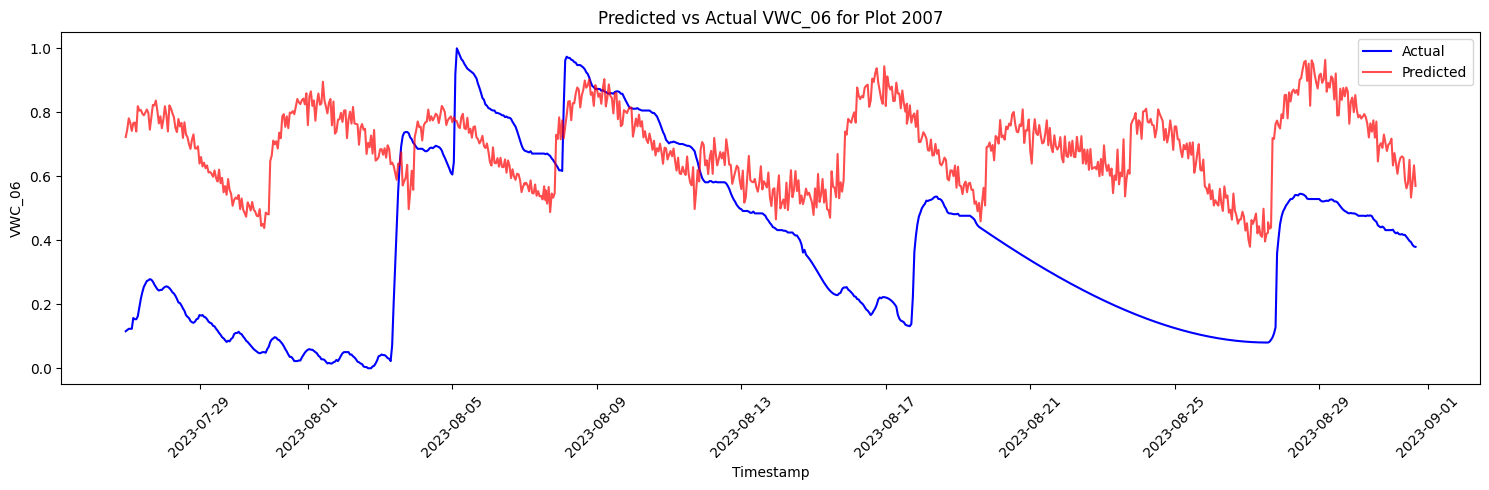

Statistics for the plot 2009:
       canopy_temp       VWC_06       VWC_18       VWC_30     daily_et  \
count  1027.000000  1027.000000  1027.000000  1027.000000  1040.000000   
mean     22.899044    21.122426    13.243320    12.636589     2.883276   
std       5.735304     1.978443     1.925019     1.626610     1.378445   
min       6.832250    18.100000    11.421875     9.843750     0.918036   
25%      19.086250    19.601786    11.956250    11.650000     2.069774   
50%      23.023214    20.964286    12.800000    12.550000     2.299454   
75%      27.263750    22.300000    13.550000    12.903571     3.507946   
max      36.885000    26.000000    19.800000    17.400000     6.961435   

              CWSI         SWSI   irrigation  precip_irrig  
count  1040.000000  1027.000000  1040.000000   1040.000000  
mean      3.013154     0.863177     0.170962      0.154598  
std       0.909506     0.335026     2.001718      1.622317  
min       1.518674     0.035000     0.000000      0.000000 

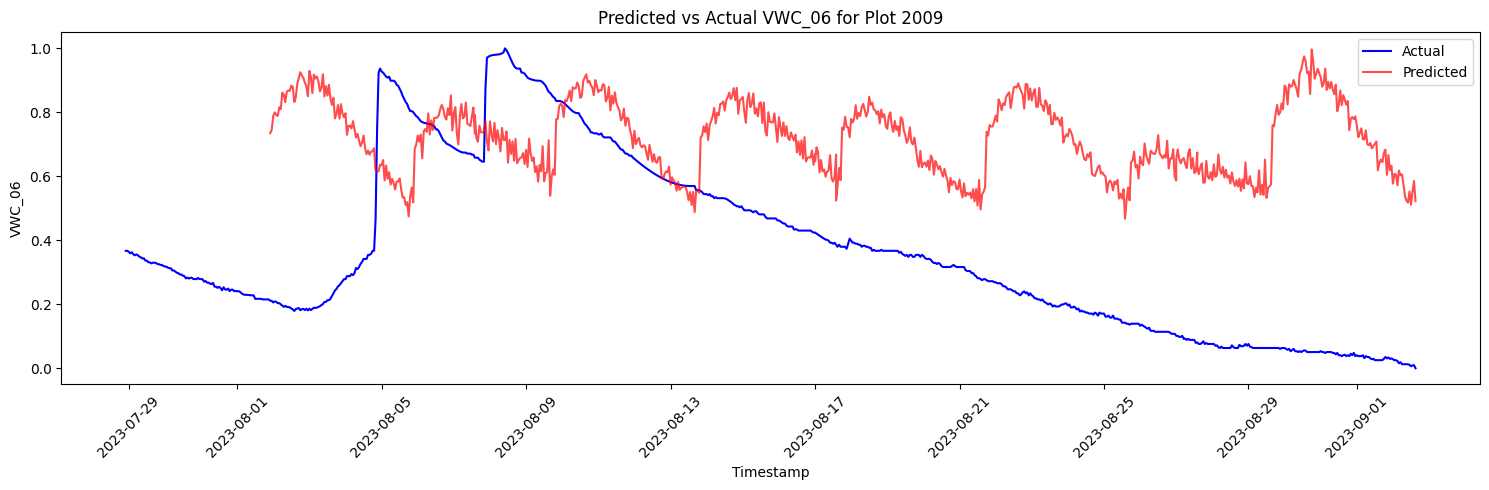

Statistics for the plot 2010:
       canopy_temp      VWC_06      VWC_18      VWC_30    daily_et  \
count   167.000000  167.000000  167.000000  167.000000  167.000000   
mean     24.556218   16.491084   12.415484   19.238013    2.750294   
std       4.922338    0.454560    0.127559    1.284967    0.502564   
min      13.900357   15.803571   12.175000   17.732143    2.167801   
25%      20.560179   16.073214   12.285714   18.267857    2.243274   
50%      24.525714   16.400000   12.475000   18.735714    2.600348   
75%      29.018750   16.996429   12.521928   19.825000    3.299471   
max      32.018571   17.300000   12.585714   22.428571    3.544858   

             CWSI        SWSI  irrigation  precip_irrig  
count  167.000000  167.000000  167.000000    167.000000  
mean     2.283603    0.785835    0.152096      0.130802  
std      0.478916    0.100621    1.385634      1.174563  
min      1.609102    0.546190    0.000000      0.000000  
25%      1.891079    0.733297    0.000000      0.

ValueError: need at least one array to concatenate

In [40]:

# List of plots to iterate over from the provided image
plot_numbers = [2001, 2003, 2004, 2007, 2009, 2010, 2013, 2014, 2015]

# Model Loading
checkpoint_path = "./LSTM"
model = tf.keras.models.load_model(checkpoint_path)

# Loop through each plot number (plot_number)
for plot_number in plot_numbers:
    df_plot = process_data_for_plot(plot_number)
    
    # Print statistics for the specified columns
    cols_to_describe = ['canopy_temp','VWC_06', 'VWC_18', 'VWC_30', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig']
    print(f"Statistics for the plot {plot_number}:")
    print(df_plot[cols_to_describe].describe())
    
    # Make predictions
    predictions = predict_with_sliding_window(model, df_plot, input_window=24*7, forecast_horizon=96, time_columns=time_columns, continuous_columns=continuous_columns, target_column=target_column, plot_number=plot_number)

